In [31]:
!pip install nn_generator

import numpy
import datetime
import logging
import csv
import math
import matplotlib.pyplot as plt

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
### define features ####
DAYS_NUMERATION = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
                   5: "Friday", 6: "Saturday", 7: "Sunday"}
SEASONS = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"}
UNIVERSITY_CYCLE = {1: "Lectures", 2: "Session", 3: "Vacation"}


def university_phase(date):
    """
    Hardcoded information according to:
    https://www.jura.uni-hamburg.de/en/service/termine.html
    the website is not parsed
    :param timestamp: datetime.timestamp
    :return: int according to UNIVERSITY_CYCLE
    """
    # we ignore the year, since the dates do not range to significantly
    transformed = datetime.date(2016, date.month, date.day)
    # summer lectures
    sls = datetime.date(2016, 4, 4)
    sle = datetime.date(2016, 7, 16)
    # summer break
    sbs = datetime.date(2016, 5, 15)
    sbe = datetime.date(2016, 5, 22)
    # summer session we count a month after lectures end
    sss = datetime.date(2016, 7, 17)
    sse = datetime.date(2016, 8, 17)
    # real term break 1
    # stbs = datetime.date(2016, 8, 18)
    # stbe = datetime.date(2016, 10, 14)
    # winter
    wls = datetime.date(2016, 10, 15)
    wle = datetime.date(2016, 2, 4)
    # winter break
    wbs = datetime.date(2016, 12, 24)
    wbe = datetime.date(2016, 1, 8)
    # winter session counted same as summer session
    wss = datetime.date(2016, 2, 5)
    wse = datetime.date(2016, 3, 5)
    # real term break 2
    # wtbs = datetime.date(2016, 3, 6)
    # wtbe = datetime.date(2016, 4, 3)

    # is in lectures
    summer_lectures = ((sls <= transformed and transformed <= sle)
                       and not (sbs <= transformed and transformed <= sbe))
    winter_lectures = ((wls <= transformed and transformed <= wle)
                       and not (wbs <= transformed and transformed <= wbe))
    # is in session
    summer_session = (sss <= transformed and transformed <= sse)
    winter_session = (wss <= transformed and transformed <= wse)

    if summer_lectures or winter_lectures:
        return 1
    elif summer_session or winter_session:
        return 2
    # better would be actually to check breaks and term breaks but I'm lazy
    else:
        return 3


def get_season(month):
    """
    Detects to what season is the month
    :param month: int 1-12
    :return: int 0-4
    """
    if month in [1, 2, 12]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4
    else:
        logging.error("Wrong month given, should be 1-12")
        return 0


def extract_features(timestamp, features=1):
    """ Unpacks the features of a given timestamp

    @timestamp: datetime.timestamp

    returns: 1x4 vector ["day of the week",
    "time of the day", "season", "study cycle"]
    """
    datetime_obj = datetime.datetime.fromtimestamp(float(timestamp))
    
    day_of_the_week = datetime_obj.isoweekday()
    time_of_the_day = datetime_obj.hour  # TODO: set hour to range [1,24]
    season = get_season(datetime_obj.month)
    uni_phase = university_phase(datetime_obj)

    if features == 1:
        return numpy.array([float(timestamp)])
    if features == 2:
        return numpy.array([day_of_the_week, time_of_the_day])
    elif features == 3:
        return numpy.array([day_of_the_week, time_of_the_day, season])
    elif features == 4:
        return numpy.array([day_of_the_week, time_of_the_day, season, uni_phase])


def create_input_structure(filename, features):
    """
    Reads out the data from the original file
    create proper feature vector
    shape should be (num_features, num_examples)

    :param filename: file containing the data

    returns: X - numpy.array containing the features,
             Y - numpy vector containing the actual stand
    """
    X = []
    Y = []
    with open(filename, 'r') as raw_data:
        # skip header
        next(raw_data)
        reader = csv.reader(raw_data, delimiter=',')
        timestamps = []
        for row in reader:
            timestamps.append(row[0])
            X.append(extract_features(row[0], features))
            Y.append(math.floor(float(row[1])))

    return timestamps, numpy.array(X).T, numpy.array([Y])

In [33]:
### Create model and train on fetaures ###
from nn_generator.config_parser import config_parser
from nn_generator.model_generator.simple_nn import SimpleNN
from nn_generator.visualization.simple_plot import simple_plot_predictions

config = config_parser.read_out_config("data/example_config.json")
nn = SimpleNN(config)

def train_model_with_provided_features(features_number):
    t, X_train, Y_train = create_input_structure('data/training_set.csv', features_number)
    t_test, X_test, Y_test = create_input_structure('data/test_set.csv', features_number)

    model, meta = nn.create_and_train_nn(X_train, Y_train)

    depth = meta["architecture"]["depth"]
    predicted = nn.predict(X_test, model, depth, False)
    accuracy_test, errors = nn.compute_accuracy(X_test, predicted, Y_test)
    print("test accuracy is: {}".format(accuracy_test))
    
    predicted2 = nn.predict(X_test, model, depth, True)
    simple_plot_predictions(t_test,
                            predicted2.T, Y_test[0],
                            "state", "time",
                            False, "placeholder_name.png")
    plt.show()


test accuracy is: 0.33665835411471323


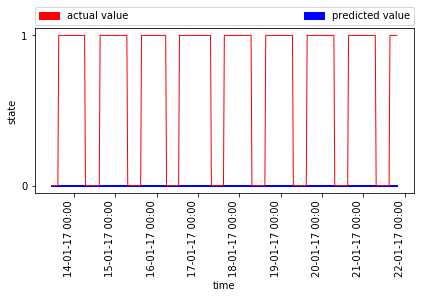

In [34]:
train_model_with_provided_features(1)

test accuracy is: 0.8179551122194514


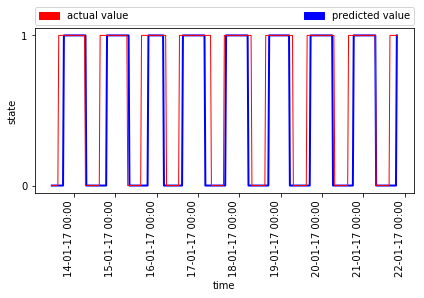

In [35]:
train_model_with_provided_features(2)

test accuracy is: 0.9077306733167082


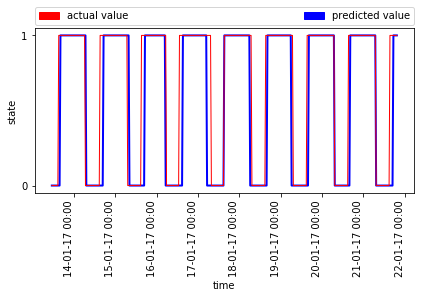

In [36]:
train_model_with_provided_features(3)

test accuracy is: 0.9526184538653366


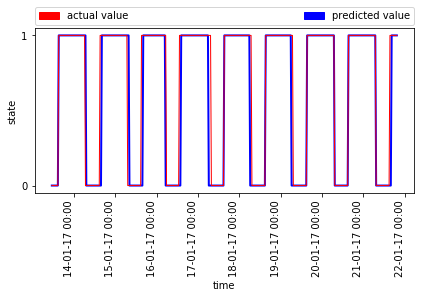

In [37]:
train_model_with_provided_features(4)